## Working environment R

We'll use both R and python a lot. What we need for R:

In [2]:
spatDir <- "/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis"
setwd(spatDir)
library(vegan)
library(phyloseq)

## our dataframes that we usually need:
comData <- read.csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv", row.names=1)
envData <- read.csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis/sulariEnv.csv", row.names=1)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



## Working Environment Python

Here's what we need for python...

In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt; plt.ion()
import os, rasterio
import rasterio.plot
import scipy.spatial as sp
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors
import pymc as pm
import preliz as pz
import arviz as az


## working directory is here:
os.chdir("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis")

## the data we usually need:
sulariEnvCSV="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis/sulariEnv.csv"
envData = pd.read_csv(sulariEnvCSV, index_col='SampleID')
comData = pd.read_csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv", 
                      index_col=0) ## don't forget to drop control rows!!


## Clean up data

Going from Sulari's spreadsheets to a format that works for us...

In [3]:
spatDir="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis"
## ^different on laptop
os.chdir(spatDir)

Get sulari's data, clean it up a little:

In [4]:
## on officeComp
sulariEnvCSV="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/Envt_Matrix.csv"
envData = pd.read_csv(sulariEnvCSV)
## get rid of spaces
envData.rename({"Sample ID":"SampleID"}, axis="columns", inplace=True)
## we need to clean up the plot.ID. Sulari recorded season in the plot IDs,
## using letter codes. Also she has one double sampling, with an underscore
envData['Plot.ID'] = envData['Plot.ID'].str.slice(0,5)

## let's get rid of decimals in the names, weird for python work:
envData.rename({"Plot.ID":"PlotID", 
       "soil.respiration":"soil_respiration",
              "Land.type":"Land_type"}, 
                axis="columns", inplace=True)

envData.head()


,SampleID,PlotID,Date,soil_respiration,srpuc,MBC,season,Land_type,pH,N,C,CNR,Temperature,Moisture,Latitude,Longitude
0,S1,P0104,04/07/2022,1.892454,74.653008,0.961063,S,Arableland,6.919,0.213,2.535,11.901408,18.9,15.797262,50.105065,11.922489
1,S2,P0156,06/07/2022,6.558051,115.703091,1.458421,S,Grassland,5.828,0.435,5.668,13.029885,16.9,9.509603,50.073714,11.954150
2,S3,P0204,05/07/2022,2.141342,59.880935,0.468984,S,Forest,4.214,0.134,3.576,26.686567,12.9,19.264706,50.055621,11.952927
3,S4,P0105,25/07/2022,2.030831,107.224446,0.568533,S,Arableland,5.520,0.164,1.894,11.548780,17.2,4.192597,50.176334,11.840065
4,S5,P0155,14/07/2022,6.476892,83.218455,2.279664,S,Grassland,7.051,0.685,7.783,11.362044,17.6,11.037206,50.129343,11.808350


In [13]:
## in the future, this is the cleaner data:
sulariEnvCSV="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis/sulariEnv.csv"
envData = pd.read_csv(sulariEnvCSV, index_col='SampleID')

envData.head()
envData.tail()

,PlotID,Date,soil_respiration,srpuc,MBC,season,Land_type,pH,N,C,CNR,Temperature,Moisture,Latitude,Longitude
SampleID,,,,,,,,,,,,,,,
S120,P0213,18/05/2022,1.067608,44.299095,0.406645,SP,Forest,4.043,0.11,2.41,21.909091,8.2,30.258169,50.220131,11.812314
C1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The following is the code for generating Sulari's ASV-level community matrix from her phyloseq object, in R. (can skip)

In [ ]:
##### R ###
#library('phyloseq')
#load("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/sularilogMin50ps.rda")
#logMin50ps
#comdat <- as.data.frame(otu_table(logMin50ps))
#comdat = comdat[,colSums(comdat) > 0] 
#write.csv(comdat, file="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv")
############


Back in python:

In [6]:
comData = pd.read_csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv", index_col=0)

comData.drop([ "C1.1", "C1.2", "C2.1", "C2.2"], inplace=True)

comData.head()


,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10,...,ASV10138,ASV10154,ASV10161,ASV10174,ASV10175,ASV10180,ASV10188,ASV10189,ASV10193,ASV10194
S1,0.000000,0.032530,0.016008,0.010700,0.011428,0.008738,0.006490,0.003053,0.020011,0.005984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S2,0.000000,0.006536,0.023847,0.010878,0.029067,0.005589,0.001848,0.000000,0.001740,0.001821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S3,0.006919,0.001895,0.003264,0.043099,0.001210,0.017189,0.042306,0.017963,0.001069,0.028395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S4,0.011532,0.020729,0.014881,0.014121,0.004279,0.005844,0.000000,0.001880,0.001911,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S5,0.000000,0.009767,0.019855,0.004334,0.018471,0.003210,0.000000,0.000000,0.027292,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Make a map of the sampling effort of Carbon4D

Make a spatial dataframe...

In [15]:
## get rid of controls
envData.drop([ "C1.1", "C1.2", "C2.1", "C2.2"], inplace=True)

plotPoints = gpd.points_from_xy( envData.Longitude, envData.Latitude, crs="EPSG:4326" )

sulariPlotsDF = gpd.GeoDataFrame(envData[[ 'PlotID', 'soil_respiration', 
                    'MBC', 'season', 'Land_type', 'pH', 'N', 'C']], geometry=plotPoints)



## to convert to UTM? looks like we are in zone 33
## looks like:
## EPSG:32633

sulariPlot_utm = sulariPlotsDF.to_crs('EPSG:32633')

sulariPlot_utm.tail()

,PlotID,soil_respiration,MBC,season,Land_type,pH,N,C,geometry
SampleID,,,,,,,,,
S116,P0203,1.022541,0.452289,SP,Forest,4.348,0.073,1.730,POINT (274684.681 5558574.847)
S117,P0209,1.650842,0.488906,SP,Forest,3.847,0.128,2.559,POINT (282466.942 5565510.521)
S118,P0105,1.468438,0.799233,SP,Arableland,5.703,0.165,1.790,POINT (274386.567 5563017.017)
S119,P0204,3.054180,0.473599,SP,Forest,3.791,0.157,4.586,POINT (281895.213 5549263.192)
S120,P0213,1.067608,0.406645,SP,Forest,4.043,0.110,2.410,POINT (272613.867 5567969.743)


And let's make some maps!

In [16]:
fichtelMap = rasterio.open("studyAreaClipped_UTM.tif")

## color code our points according to land type?
cdik={
"Arableland":"b",
"Grassland":"y",
"Forest":"g",
}
sulariPlotsDF['landColors'] = [ cdik[i] for i in sulariPlotsDF['Land_type'] ]
sulariPlot_utm['landColors'] = [ cdik[i] for i in sulariPlotsDF['Land_type'] ]


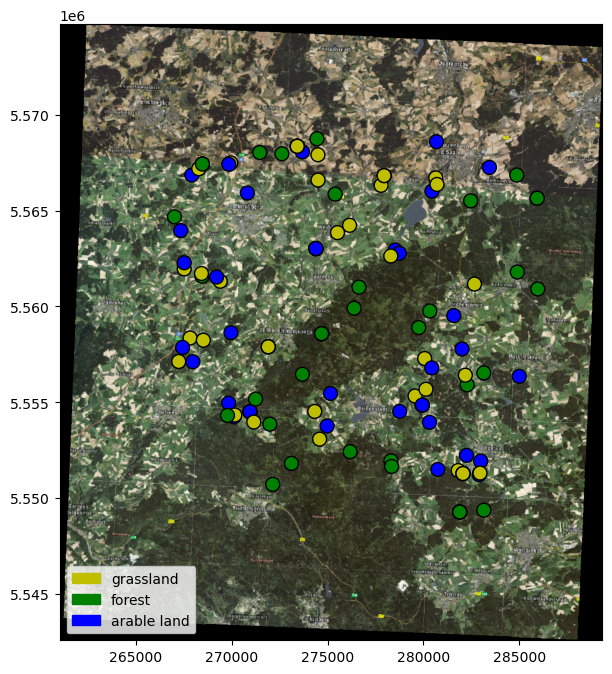

In [17]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
rasterio.plot.show(fichtelMap, ax=ax)
sulariPlot_utm.plot(
    marker="o",
    ax=ax,
    edgecolor='k',
    facecolor=sulariPlotsDF['landColors'],
    markersize=100)

grassPatch = Patch(color='y', label='grassland',)
forestPatch = Patch(color='g', label='forest')
farmPatch = Patch(color='b', label='arable land')
ax.legend(handles=[grassPatch, forestPatch, farmPatch],
          loc="lower left",
          fontsize=10,
)





# Alpha diversity

How do our alpha diversities from the various land use types? Preliminary alpha diversity results from Sulari's phyloseq scripts are mixed, at times suggestive of differences in raw species abundance. But our bioinformatics pipeline retains only relatively common species, to reduce error from the sequencer. How does our alpha diversity look after these transformations?

First, let's check rarefaction curves to make sure the samples are actually fair to compare. Did we actually sequence deep enough in all cases to get all the ASVs? We are using our weird, transformed abundances, so let's multiply them and round to get fake counts so that we rarefy:

In [3]:
notControls=!(row.names(comData) %in% c("C1.1", "C1.2", "C2.1", "C2.2"))
comData = comData[notControls,]
envData = envData[notControls,]

In [4]:
min(comData[ comData > 0 ]) ## our smallest non-zero observation 


[1] 0.0007840309

In [20]:
## so we need to multiply by ~10000 and round up
comDataFakeCounts = ceiling(comData * 10000)
min(comDataFakeCounts[ comDataFakeCounts > 0 ]) ## our smallest non-zero observation is now 8 
max(comDataFakeCounts[ comDataFakeCounts > 0 ]) ## largest single observation of an ASV is now 1119


[1] 8

[1] 1119

[1] 10001

Warning message in rarefy(comDataFakeCounts, raremax):
“most observed count data have counts 1, but smallest count is 8”
Warning message in rarecurve(comDataFakeCounts, step = 20, sample = raremax, col = "blue", :
“most observed count data have counts 1, but smallest count is 8”


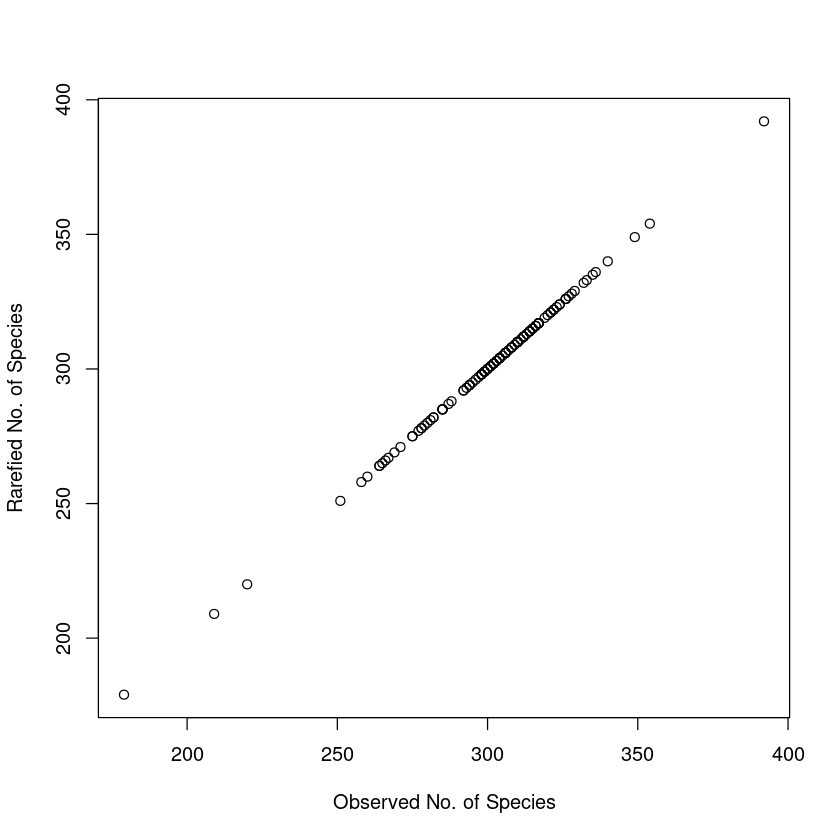

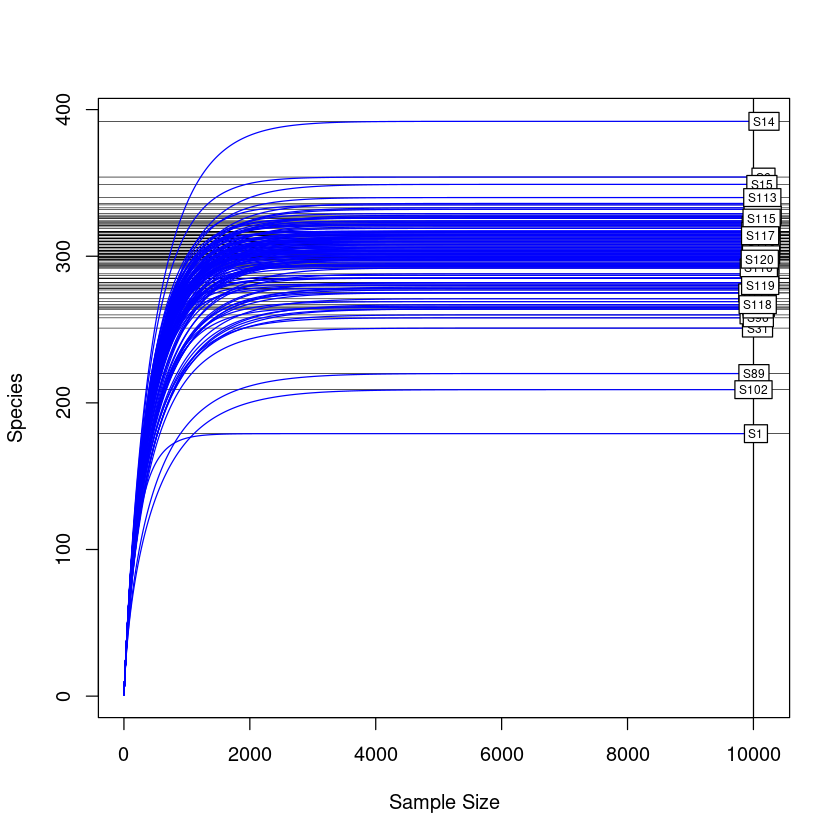

In [21]:
S <- specnumber(comDataFakeCounts) # observed number of species

(raremax <- min(rowSums(comDataFakeCounts))) ## 10001

Srare <- rarefy(comDataFakeCounts, raremax)

plot(S, Srare, xlab = "Observed No. of Species", ylab = "Rarefied No. of Species")

rarecurve(comDataFakeCounts, step = 20, sample = raremax, col = "blue", cex = 0.6)


There is a 100% correlation between total species richness and species observed when rarefied to the same number of individuals. And those are saturated curves even at the number of individuals in the smallest samples. So rarefying isn't really necessary here, these species richness estimates are comparable among all our samples. 

Our numbers of ASVs seem very conservative, 200-400 ASVs/(0.25 g/soil). But makes sense, we have a pretty strict cutoff. This pipeline was intended to maximize comparability among samples for beta diversity analysis and to examine the role of common bacterial species in the soil. If someone asks for the "real" diversity numbers, or a number that includes our best estimate of the number of rare species, we can dig deeper. But I'm not super interested in that at this point.

mean alpha diversity of all sites = 301.38 +/- 26 ASVs

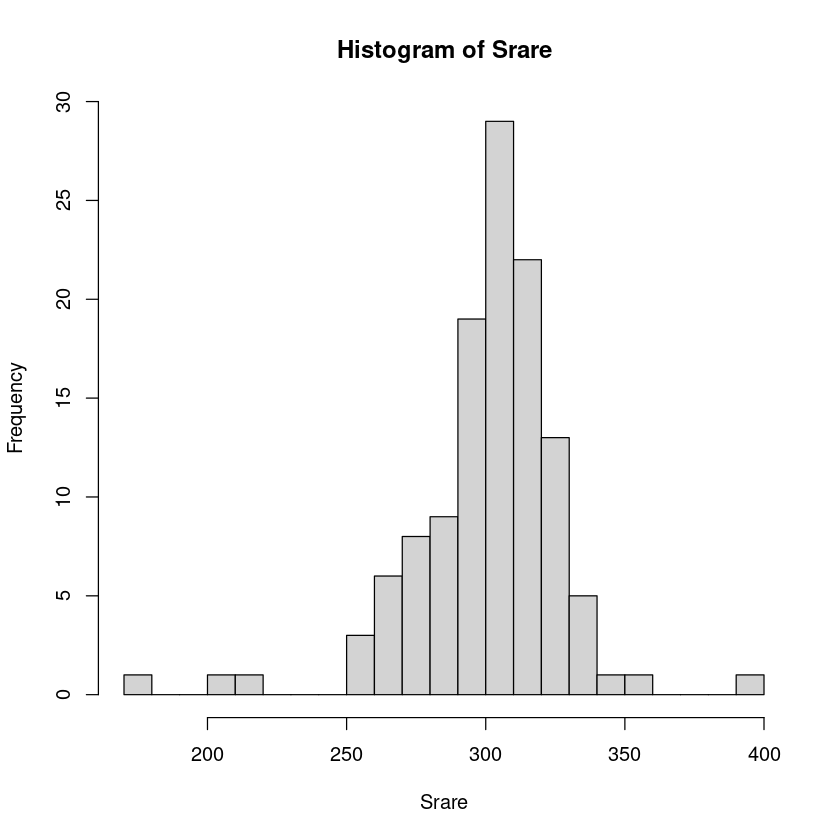

In [25]:
hist(Srare, 20) ## looks more or less normal.
cat(paste("mean alpha diversity of all sites =", round(mean(Srare),2), "+/-", round(sd(Srare)), "ASVs"))


This looks pretty normal. That means we can do a quick one-way ANOVA to check for differences among the land types in species richness.

                   Df Sum Sq Mean Sq F value Pr(>F)  
envData$Land_type   2   3859  1929.5   2.852 0.0618 .
Residuals         117  79155   676.5                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

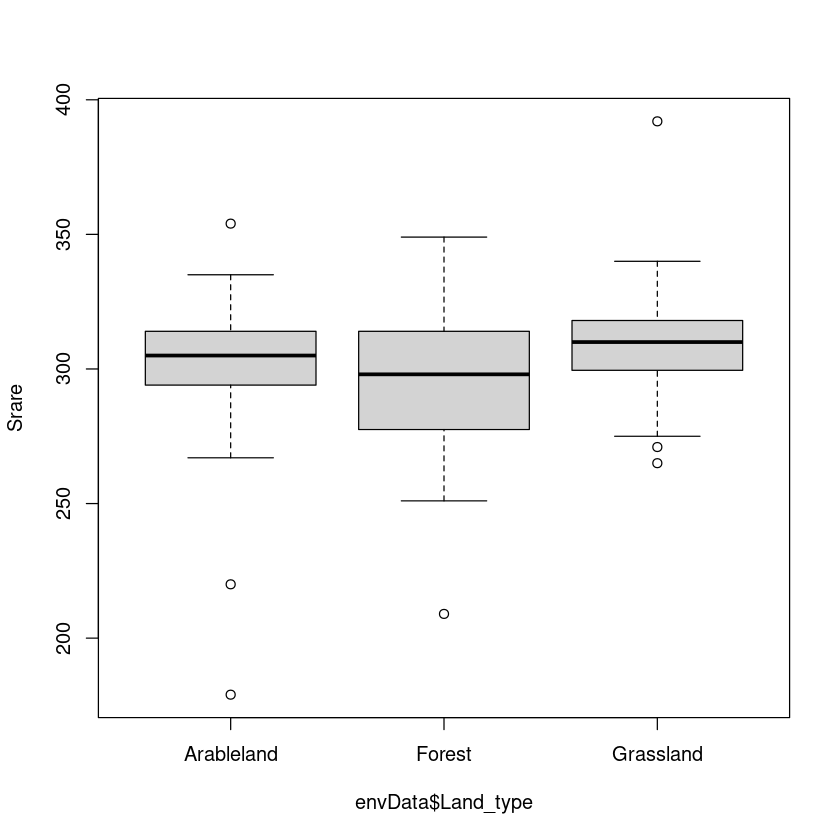

In [27]:
boxplot(Srare ~ envData$Land_type)

## anova
res.aov <- aov(Srare ~ envData$Land_type)
summary(res.aov)


Among the three groups there is not a dramatic difference in alpha diversity. The "near-significance" comes from the contrast between grassland and forest soils:

In [28]:
noFarms <- envData$Land_type != "Arableland"
t.test(Srare[noFarms] ~ envData$Land_type[noFarms])


	Welch Two Sample t-test

data:  Srare[noFarms] by envData$Land_type[noFarms]
t = -2.4814, df = 70.888, p-value = 0.01546
alternative hypothesis: true difference in means between group Forest and group Grassland is not equal to 0
95 percent confidence interval:
 -25.157788  -2.739648
sample estimates:
   mean in group Forest mean in group Grassland 
               294.9487                308.8974 


So as was the case in the Rodriguez paper, the grasslands show a higher alpha diversity than the forest, but see next section on beta diversity.

But let's do this in the Bayesian way...get a posterior for each group and see how much the means differ. We'll use PyMC3 for the bayesian stuff. 

In [13]:
## set kernel to python
controls=[ 'C1.1', 'C1.2', 'C2.1', 'C2.2']
envData.drop(controls, axis='rows', inplace=True)
comData.drop(controls, axis='rows', inplace=True)

In [14]:
## remake our species richness here:
aa = comData.copy()
aa[aa > 0] = 1

specRich = aa.sum(axis="columns")

specRichLT = (pd.concat([pd.to_numeric(specRich, downcast='integer'), envData['Land_type']], axis='columns')
                     .rename({0:"spRich"},axis="columns"))

specRichLT.head()

,spRich,Land_type
S1,179,Arableland
S2,322,Grassland
S3,282,Forest
S4,293,Arableland
S5,306,Grassland


array([<Axes: >], dtype=object)

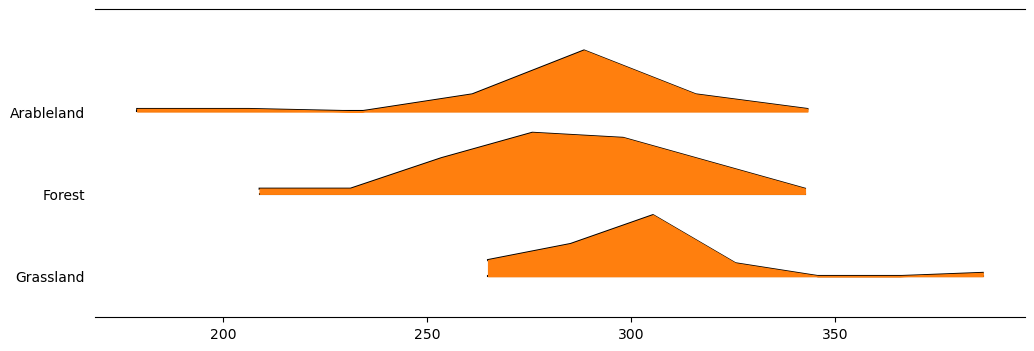

In [15]:
az.plot_forest(specRichLT.pivot(columns="Land_type", values="spRich").to_dict("list"),
               kind="ridgeplot",
               hdi_prob=1,
               colors="C1",
               figsize=(12, 4))


In [19]:
## oswaldo's confusing code for creating an index, adapted for our data:
categories = np.array(["Arableland", "Grassland", "Forest"])
spr = specRichLT["spRich"].values
idx = pd.Categorical(specRichLT["Land_type"], categories=categories).codes
coords = {"Land_type": categories, "land_type_flat":categories[idx]}

## make the model. Use cauchy because of outliers
with pm.Model(coords=coords) as model_t:
    μ = pm.Normal("μ", mu=300, sigma=50, dims="Land_type")
    σ = pm.HalfNormal("σ", sigma=20, dims="Land_type")
    ν = pm.Exponential('ν', 0.1, dims="Land_type") ## exponential gets flatter with lower values, mean gets pulled away from zero
    y = pm.StudentT('Species richness', nu=ν[idx], mu=μ[idx], sigma= σ[idx], observed=spr, dims="land_type_flat")
    idata_cg = pm.sample(random_seed=4591, chains=4)
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg, random_seed=4591))



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [μ, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [Species richness]


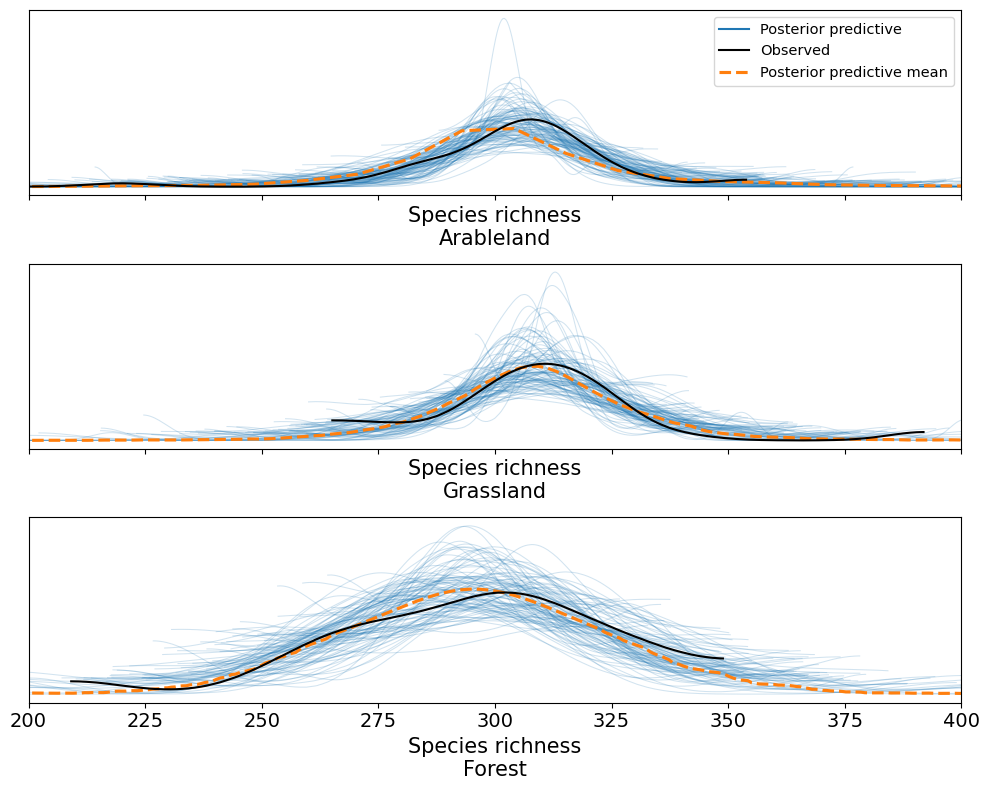

In [27]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,8))
az.plot_ppc(idata_cg, num_pp_samples=100, coords={"land_type_flat":[categories]}, flatten=[], ax=axes)
axes[0].set_xlim(200,400)
axes[1].get_legend().remove()
axes[2].get_legend().remove()
fig.tight_layout()


Looks right. Forest has a much greater variation of species richness, also.

# Beta-diversity 

## Ordinations

Let's repeat the ordinations first created by Sulari in her thesis, and add in some info to them. I like the vegan package, so start in R, then move over to python for plotting.

In [1]:
## did you change your kernel to R?
library(vegan)

spatDir <- "/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis"
setwd(spatDir)

comData=read.csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv", row.names=1)
envData=read.csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis/sulariEnv.csv", row.names=1)
## get rid of controls
notControls=!(row.names(comData) %in% c("C1.1", "C1.2", "C2.1", "C2.2"))
comData <- comData[notControls,]
envData <- envData[notControls,]


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



In [2]:
comNMS <- metaMDS(comData, try=40)

write.csv(comNMS$points, file='comNMS.csv')

Run 0 stress 0.07098847 
Run 1 stress 0.07438622 
Run 2 stress 0.07636368 
Run 3 stress 0.07225162 
Run 4 stress 0.07332606 
Run 5 stress 0.07233947 
Run 6 stress 0.07236572 
Run 7 stress 0.07602231 
Run 8 stress 0.07446346 
Run 9 stress 0.07409039 
Run 10 stress 0.07488779 
Run 11 stress 0.07311241 
Run 12 stress 0.07613841 
Run 13 stress 0.07514103 
Run 14 stress 0.07383281 
Run 15 stress 0.07619491 
Run 16 stress 0.07374372 
Run 17 stress 0.07561621 
Run 18 stress 0.07308779 
Run 19 stress 0.07549539 
Run 20 stress 0.07631217 
*** Best solution was not repeated -- monoMDS stopping criteria:
    20: stress ratio > sratmax


In python...

In [17]:
## data
nmsPts = pd.read_csv("comNMS.csv", index_col=0)
controls=[ 'C1.1', 'C1.2', 'C2.1', 'C2.2']
envData.drop(controls, axis='rows', inplace=True)
comData.drop(controls, axis='rows', inplace=True)


First ordination is just land use:

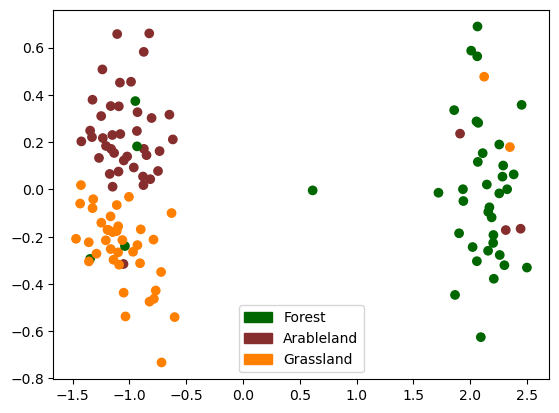

In [5]:
colorDict = {
'Arableland':'#862d2d',
'Forest'    :'#006600',
'Grassland' :'#FF7F00'
}
landCols = [ colorDict[i] for i in envData['Land_type'] ]

plt.close('all')
fig, ax = plt.subplots()
ax.scatter(x=nmsPts["MDS1"],
           y=nmsPts["MDS2"],
           c=landCols,
          )

Arableland_patch = Patch(color='#862d2d', label='Arableland')
Forest_patch = Patch(color='#006600', label='Forest')
Grassland_patch = Patch(color='#FF7F00', label='Grassland')
ax.legend(handles=[Forest_patch, Arableland_patch, Grassland_patch])


Pretty clear separation of microbial communities by land type. 

There are samples in this dataset from different communities. Does this make much difference, at least in the ordinations?

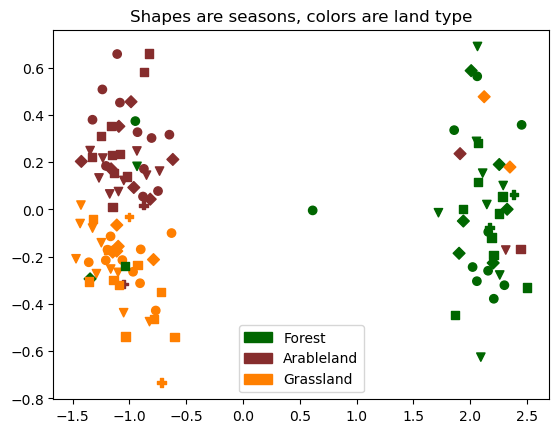

In [27]:
seasonDict = {
     'S': "o",
    'SP': "v",
    'W1': "D",
    'W2': "P",
     'A': "s",
}

fig, ax = plt.subplots()
for i in envData.season.unique():
  env_i = envData[envData['season'] == i]
  plots_i = env_i.index.to_list()
  nmsPts_i = nmsPts.loc[plots_i]
  cols_i = [ colorDict[i] for i in env_i['Land_type'] ]
  ax.scatter(x=nmsPts_i["MDS1"],
             y=nmsPts_i["MDS2"], 
             c=cols_i,
        marker=seasonDict[i],
            )


ax.set_title('Shapes are seasons, colors are land type')
Arableland_patch = Patch(color='#862d2d', label='Arableland')
Forest_patch = Patch(color='#006600', label='Forest')
Grassland_patch = Patch(color='#FF7F00', label='Grassland')
ax.legend(handles=[Forest_patch, Arableland_patch, Grassland_patch])


Doesn't seem like a dramatic effect, but further investigation needed.

Let's also visualize pH and respiration. We will indicate pH by color, land type by symbol, and respiration by size:

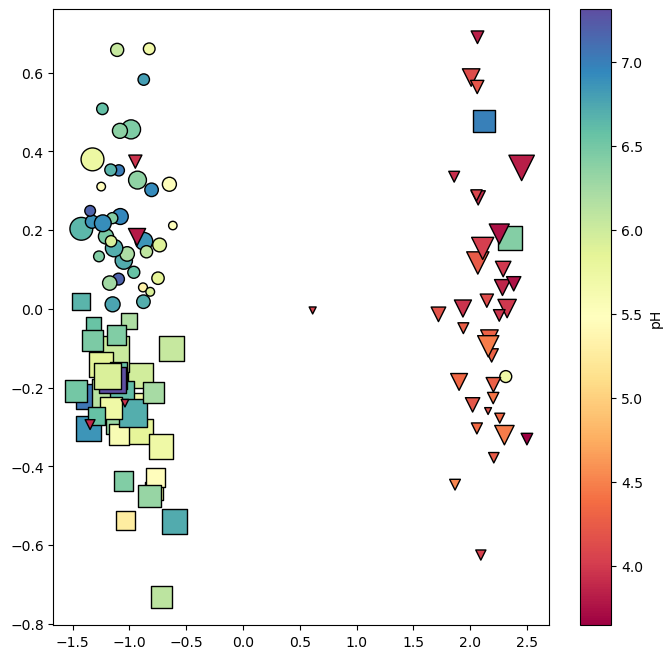

In [26]:
landTypeShapesDict = {
'Arableland': "o",
'Forest'    : "v",
'Grassland' : "s",
}

pHmin = envData['pH'].min() ## 3.647
pHmax = envData['pH'].max() ## 7.312
norm=matplotlib.colors.Normalize(pHmin, pHmax)
plt.close('all')
fig, ax = plt.subplots(figsize=(8,8))
for i in envData.Land_type.unique():
  env_i = envData[envData['Land_type'] == i]
  plots_i = env_i.index.to_list()
  nmsPts_i = nmsPts.loc[plots_i]
  sizes = env_i['soil_respiration']*50
  ax.scatter(x=nmsPts_i["MDS1"],
             y=nmsPts_i["MDS2"],
             #s=140,
             s=sizes,
             c=env_i['pH'],
             cmap='Spectral',
             edgecolors='black',
             marker=landTypeShapesDict[i],
             norm=norm,
            )

fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(pHmin, pHmax), cmap='Spectral'),
             ax=ax, orientation='vertical', label='pH')


Squares are grassland, circles are cropland, and triangles are forest. Color is pH. Size is scaled to respiration/g. There is a clear signature of low pH in the forest soils, which isn't really a surprise. The grasslands are clearly respiring more, on average. 

## Community turnover

We predict that forest soils show higher community turnover than grasslands and maybe cropland, because of the more sheltered but more complex forest environment. Total community turnover across the entire study looks like this:

Text(0.5, 0, 'Physical distance (m) between sites')

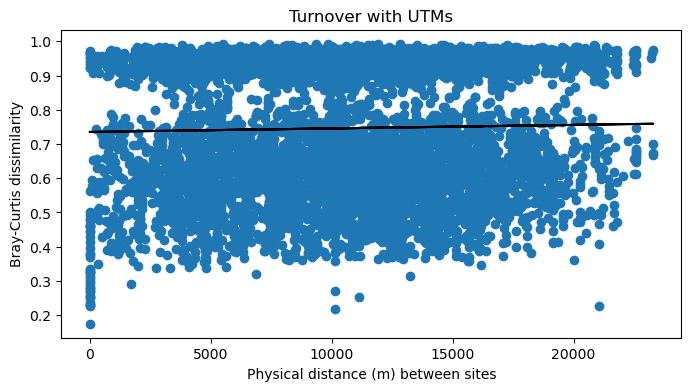

In [18]:
## utms
plt.rcParams['figure.figsize'] = [8, 4]
aa = pd.DataFrame({'xx':sulariPlot_utm.geometry.x, 'yy':sulariPlot_utm.geometry.y})
physDist = sp.distance.pdist(aa, metric='euclidean')
bcDist = sp.distance.pdist(comData, metric='brayCurtis')
fig, ax = plt.subplots()
ax.scatter(physDist, bcDist)
X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
ax.plot( X, LinearRegression().fit(X, Y).predict(X), c='k')
ax.set_title(label="Turnover with UTMs", loc='center')
ax.set_ylabel("Bray-Curtis dissimilarity")
ax.set_xlabel("Physical distance (m) between sites")


Pretty flat. BC stays around .75 across the study. But if we break this up by land use: 

Arableland LinregressResult(slope=2.810886008879302e-06, intercept=0.5742255266887255, rvalue=0.07906122967378831, pvalue=0.020333288082787844, stderr=1.2092650739802349e-06, intercept_stderr=0.01336493003583653)
Grassland LinregressResult(slope=4.1355869330822044e-07, intercept=0.559056873685921, rvalue=0.012708447690178985, pvalue=0.7298157896065757, stderr=1.1969812747713315e-06, intercept_stderr=0.013504959623407592)
Forest LinregressResult(slope=5.843245351182222e-06, intercept=0.6024952517397398, rvalue=0.20458396890349245, pvalue=1.9186466990833152e-08, stderr=1.0284330215725858e-06, intercept_stderr=0.012592597769310465)


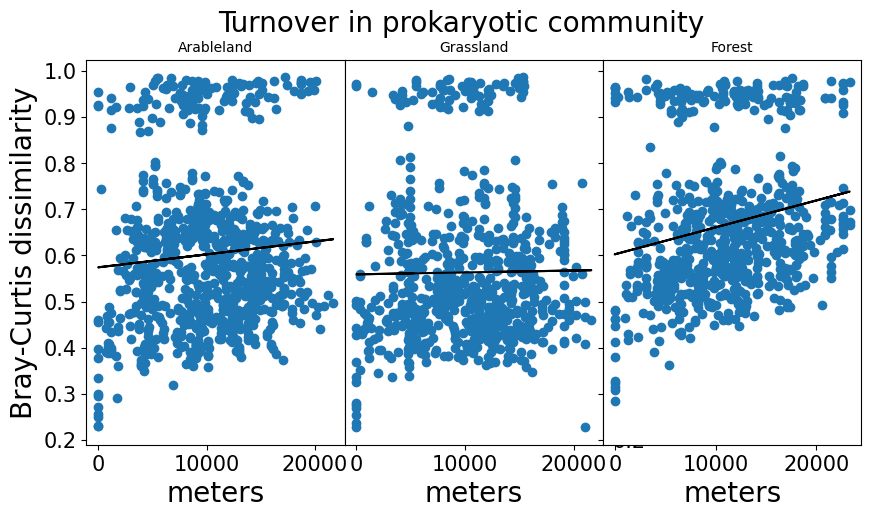

In [19]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
lts = [ "Arableland" ,"Grassland" ,"Forest"]
#lts = [ "Grassland" ,"Forest"]
fig, axes = plt.subplots(nrows=1, ncols=len(lts), sharey=True)
axes = axes.flatten()
for nu,lt in enumerate(lts):
    edf = sulariPlot_utm[sulariPlot_utm['Land_type'] == lt]
    cdf = comData.loc[edf.index]
    aa = pd.DataFrame({'xx':edf.geometry.x, 'yy':edf.geometry.y})
    physDist = sp.distance.pdist(aa, metric='euclidean')
    bcDist = sp.distance.pdist(cdf, metric='brayCurtis')
    axes[nu].scatter(physDist, bcDist)
    X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
    linMod =  LinearRegression().fit(X, Y)
    axes[nu].plot( X, linMod.predict(X), c='k')
    axes[nu].set_title(label=lt, size=10, loc='center')
    axes[nu].set_xlabel('meters', size=20)
    print(lt, stats.linregress(physDist,bcDist))


fig.suptitle("Turnover in prokaryotic community", size=20)
axes[0].set_ylabel('Bray-Curtis dissimilarity', size=20)
axes[1].tick_params(left=False, labelleft=False, right=True, labelright=True, color='red', axis='y')
plt.subplots_adjust(wspace = 0)



Forest shows a higher community turnover across space and higher dissimilarity among sites generally. 

# Gamma diversity

Let's run some total diversity estimates, for the study at large, and subsetted by land type. We'll use the vegan package in R for the statistics.

In [9]:
## set kernel to R
##check, matrices in same order?
all(row.names(comData) == row.names(envData))

[1] TRUE

Warning message in cor(x > 0):
“the standard deviation is zero”


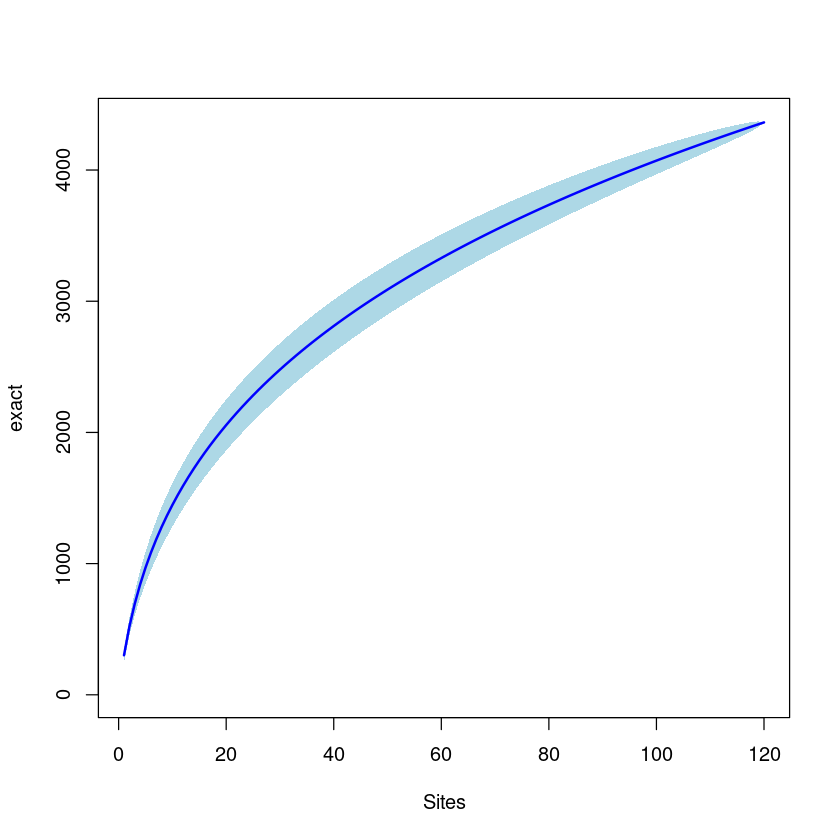

In [10]:
## if same order rows...
## get rid of controls
notControls=!(row.names(comData) %in% c("C1.1", "C1.2", "C2.1", "C2.2"))
comData = comData[notControls,]
envData = envData[notControls,]

sp1 <- specaccum(comData)

plot(sp1, ci.type="poly", col="blue", lwd=2, ci.lty=0, ci.col="lightblue")


Doesn't look saturated. Species estimaters:

In [11]:
specpool(comData)

,Species,chao,chao.se,jack1,jack1.se,jack2,boot,boot.se,n
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
All,4363,6579.995,149.4703,5991.317,191.0279,7017.983,5066.606,96.46889,120


But this isn't really meaningful, one of my main hypotheses is that soil from different sites will contribute differently to gamma diversity. Let's use vegan to make our data, but go into python for plotting, it's better.

In [18]:
for (lt in c('Arableland','Grassland', 'Forest')){
    print(lt)
    justThisLandtype=row.names(envData[envData['Land_type'] == lt,])
    comm.i <- comData[ justThisLandtype,]
    specAccum.i <- specaccum(comm.i)
    SACdf.i <- data.frame(specAccum.i$richness, specAccum.i$sd)
    colnames(SACdf.i) <- c('richness', 'sd')
    speciesEstimators.i = specpool(comm.i)
    print(speciesEstimators.i)
    write.csv(SACdf.i, file=paste(lt, "SAC.csv", sep="_"))
    write.csv(speciesEstimators.i, file=paste(lt, "specEst.csv", sep="_"))
}


[1] "Arableland"


Warning message in cor(x > 0):
“the standard deviation is zero”


    Species     chao  chao.se   jack1 jack1.se    jack2     boot  boot.se  n
All    2306 3598.294 112.8229 3261.69 224.1609 3857.718 2719.575 122.6923 42
[1] "Grassland"


Warning message in cor(x > 0):
“the standard deviation is zero”


    Species     chao  chao.se    jack1 jack1.se    jack2     boot  boot.se  n
All    2016 3107.307 102.3755 2838.359 218.0128 3345.324 2370.928 120.3828 39
[1] "Forest"


Warning message in cor(x > 0):
“the standard deviation is zero”


    Species     chao  chao.se    jack1 jack1.se    jack2     boot  boot.se  n
All    2588 4378.682 140.6374 3797.179 262.2356 4587.487 3104.188 134.2566 39


Now move to matplotlib...

In [2]:
def plotSACs(habtype, color='black', ax=None):
    if ax is None: fig, ax = plt.subplots()
    sacs = [ i for i in os.listdir() if "_SAC.csv" in i  ]
    sacName = (habtype +'_SAC.csv')
    assert( (habtype +'_SAC.csv') in sacs)
    specEstName = (habtype + "_specEst.csv")
    sac_i = pd.read_csv(sacName, index_col=0)
    specEst_i = pd.read_csv(specEstName, index_col=0).loc['All']
    specEst_i.index = specEst_i.index.str.replace(".","_")
    X = sac_i.index
    ax.plot(X, sac_i['richness'], color=color)
    ax.fill_between(x=X,
                     y1=sac_i.richness - sac_i.sd,
                     y2=sac_i.richness + sac_i.sd,
                    alpha=0.4,
                    color=color,
                    )

Text(0, 0.5, 'Prokaryotic ASVs')

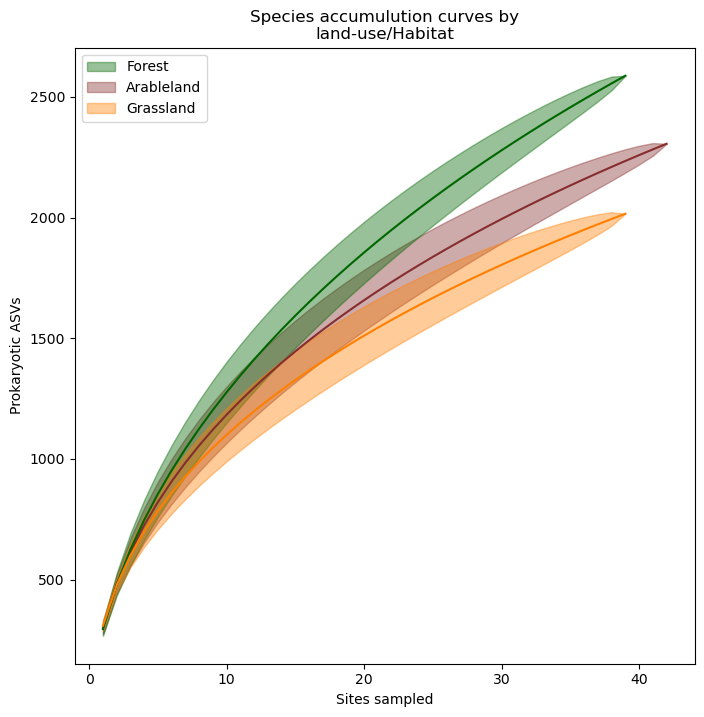

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
plotSACs('Arableland', ax=ax, color='#862d2d')
plotSACs('Forest', ax=ax, color='#006600')
plotSACs('Grassland', ax=ax, color='#FF7F00')

Arableland_patch = Patch(color='#862d2d', label='Arableland', alpha=0.4)
Forest_patch = Patch(color='#006600', label='Forest', alpha=0.4)
Grassland_patch = Patch(color='#FF7F00', label='Grassland', alpha=0.4)

ax.legend(handles=[Forest_patch, Arableland_patch, Grassland_patch])
ax.set_title('Species accumulution curves by\nland-use/Habitat')
ax.set_xlabel('Sites sampled')
ax.set_ylabel('Prokaryotic ASVs')

Forests, if equally and sufficiently sampled within the region, are expected to show significantly more species richness that agricultural and especially grassland soils.

# Respiration

## Respiration spatial trends

First step: make a map.

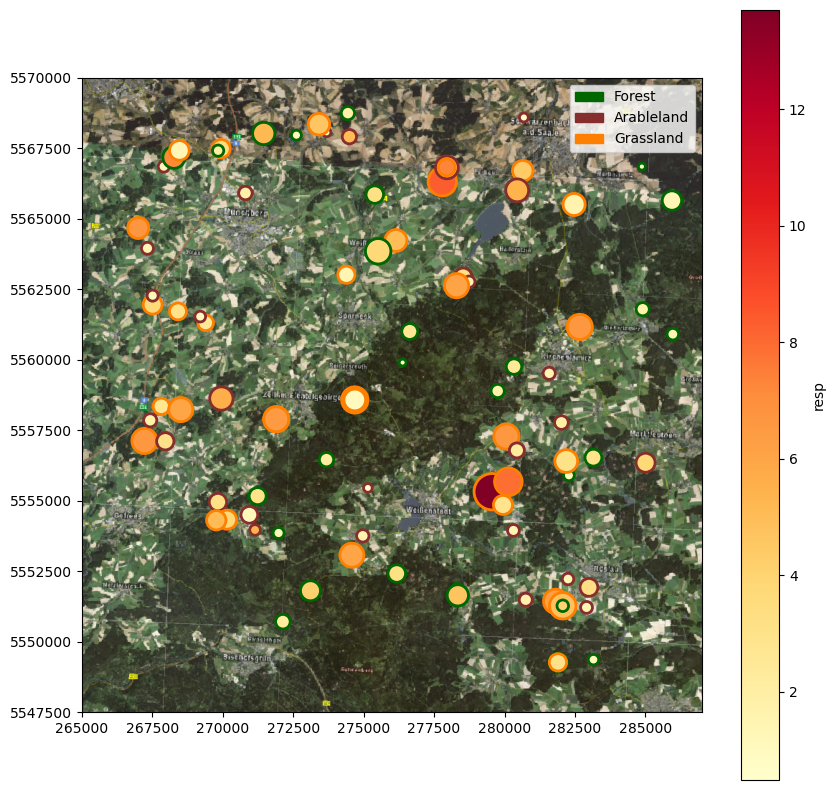

In [32]:
## get a geopandas spdf
plotPoints = gpd.points_from_xy( envData.Longitude, envData.Latitude, crs="EPSG:4326" )
sulariPlotsDF = gpd.GeoDataFrame(envData[[ 'PlotID', 'soil_respiration',
                    'MBC', 'season', 'Land_type', 'pH', 'N', 'C']], geometry=plotPoints)

sulariPlot_utm = sulariPlotsDF.to_crs('EPSG:32633')

## this map is all we have for a background right now.
fichtelMap = rasterio.open("studyAreaClipped_UTM.tif")

landColorDict = {
'Arableland':'#862d2d',
'Forest'    :'#006600',
'Grassland' :'#FF7F00'
}
landCols = [ landColorDict[i] for i in sulariPlot_utm['Land_type'] ]

fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(fichtelMap, ax=ax)
ax.ticklabel_format(useOffset=False, style='plain')
sulariPlot_utm.plot(
    marker="o",
    ax=ax,
    cmap='YlOrRd',
    #cmap='RdPu',
    column='soil_respiration',
    edgecolors=landCols,
    linewidth=2,
    markersize=sulariPlot_utm['soil_respiration']*50,
     )

ax.set_ylim(5547500, 5570000)
ax.set_xlim(265000, 287000)
respMin = envData['soil_respiration'].min() ## 0.488057256
respMax = envData['soil_respiration'].max() ## 13.70117879
fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(respMin, respMax), cmap='YlOrRd'),
             ax=ax, orientation='vertical', label='resp')
Arableland_patch = Patch(color='#862d2d', label='Arableland')
Forest_patch = Patch(color='#006600', label='Forest')
Grassland_patch = Patch(color='#FF7F00', label='Grassland')
ax.legend(handles=[Forest_patch, Arableland_patch, Grassland_patch])


Size and color are scaled by basal respiration rates. Hard to see much there except the same as noted from the ordinations: grasslands respire heavily.